## Setup


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
#!conda activate gnngeometry

In [4]:
import torch
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math, random, torch, collections, time, torch.nn.functional as F, networkx as nx, matplotlib.pyplot as plt, numpy as np
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from IPython.display import clear_output
from torch_geometric.utils import to_networkx
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from functools import wraps

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())
    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

## Generate Closed Helix

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import torch
from sklearn.neighbors import kneighbors_graph
import scipy as sc
import sklearn as sk
from sklearn.preprocessing import StandardScaler
import torch
from torch_geometric.data import Data
from torch_geometric.utils import from_scipy_sparse_matrix, to_undirected

def generate_sphere(r=1, alpha = 1, beta = 1, seed = 1234, n_samples = 3000, n_neighbours = 5, features = 'coordinates', standardize=True):
  random.seed(1234)
  theta = 2 * math.pi * np.random.beta(a = alpha,b = beta, size= n_samples)
  phi =  math.pi * np.random.beta(a = alpha, b = beta, size = n_samples)
  x = r * np.cos(theta) * np.sin(phi)
  y = r * np.sin(theta) * np.sin(phi)
  z = r * np.cos(phi)
  X = np.vstack([np.array(x), np.array(y), np.array(z)]).T
  A = kneighbors_graph(X, n_neighbours, mode='distance', include_self=False)
  edge_index, edge_weights = from_scipy_sparse_matrix(A)
  edge_index, edge_weights = to_undirected(edge_index, edge_weights)
  if standardize:
      preproc = StandardScaler()
      X = preproc.fit_transform(X)
  if features == 'coordinates':
      new_data = Data(x=torch.from_numpy(X).float(),
                      edge_index=edge_index,
                      edge_weight=edge_weights)
  else:
      new_data = Data(x=torch.eye(n_samples), edge_index=edge_index,
                      edge_weight=edge_weights)
  return x,y,z, A, new_data

In [ ]:
def generate_helix(alpha = 1, beta = 1, seed = 1234, n_samples = 3000, n_neighbours = 5, features = 'coordinates', standardize=True):
  random.seed(1234)
  theta = 8 * math.pi * np.random.beta(a = alpha,b = beta, size= n_samples)
  phi = 4 * math.pi * np.random.beta(a = alpha, b = beta, size = n_samples)
  n =  np.random.uniform(0,1,n_samples)
  #x=(1.2+0.1*np.cos(phi))*np.cos(theta)
  #y=(1.2+0.1*np.cos(phi))*np.sin(theta)
  theta = np.sort(theta)
  x = n*np.cos(theta)
  y = n*np.sin(theta)
  #z=0.1*np.sin(phi)+theta/np.pi
  z = theta/np.pi 
  X = np.vstack([np.array(x), np.array(y), np.array(z)]).T
  A = kneighbors_graph(X, n_neighbours, mode='distance', include_self=False)
  edge_index, edge_weights = from_scipy_sparse_matrix(A)
  edge_index, edge_weights = to_undirected(edge_index, edge_weights)
  if standardize:
      preproc = StandardScaler()
      X = preproc.fit_transform(X)
  if features == 'coordinates':
      new_data = Data(x=torch.from_numpy(X).float(),
                      edge_index=edge_index,
                      edge_weight=edge_weights)
  else:
      new_data = Data(x=torch.eye(n_samples), edge_index=edge_index,
                      edge_weight=edge_weights)
  return x,y,z, A, new_data

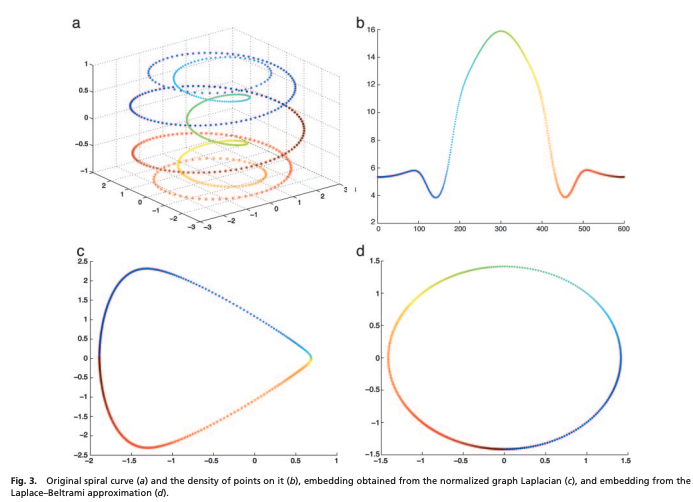

need to generate helix curve rather than spheres?

image.png

reference: https://github.com/goroda/diffusion_maps/blob/main/gendata.py

In [30]:
import argparse
import sys
import numpy as np

def get_vhelix(uniform=True, a = 0.5, b = 0.5, seed = 1234, n_samples = 3000, n_neighbours = 5, features = 'coordinates', standardize=True):
    # plot vertical helix
    # CANNOT REPRODUCE THE COIFMAN PAPER YET
    npts = n_samples
    if uniform is True:
        time = np.linspace(0, 1, npts);
    else:
        np.random.seed(seed)
        time = np.sort(np.random.beta(a, b, size=(npts)))


    height = np.sin(1.0 * np.pi * time)
    radius = np.sin(2.0 * 2.0 * np.pi * time) + 2.0
    x = radius * np.cos(5 * 2 * np.pi * time)
    y = radius * np.sin(5 * 2 * np.pi * time)

    X = np.vstack([np.array(x), np.array(y), np.array(height)]).T
    A = kneighbors_graph(X, n_neighbours, mode='distance', include_self=False)
    edge_index, edge_weights = from_scipy_sparse_matrix(A)
    edge_index, edge_weights = to_undirected(edge_index, edge_weights)
    if standardize:
      preproc = StandardScaler()
      X = preproc.fit_transform(X)
    if features == 'coordinates':
        new_data = Data(x=torch.from_numpy(X).float(),
                        edge_index=edge_index,
                        edge_weight=edge_weights)
    else:
        new_data = Data(x=torch.eye(n_samples), edge_index=edge_index,
                        edge_weight=edge_weights)
    return x,y, height, time, A, new_data

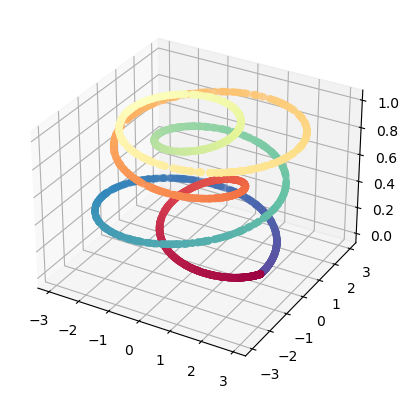

In [31]:
x,y,z,t,_,new_data = get_vhelix(uniform = False)
fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter(x,y,z, cmap = plt.cm.Spectral_r, c = t)

source: https://rdrr.io/github/kcf-jackson/maniTools/src/R/simulate_data.R

In [16]:
#' Toroidal Helix by Coifman & Lafon
#' @param N integer; Number of datapoints.
#' @param sample_rate numeric; Sampling rate.
#' @export
def toroidal_helix(N, sample_rate = 1.0):
  """
  input: number of samples
  output: data, color
  """
  noiseSigma = 0.05 #noise parameter
  t = np.arange(1,N+1) / N
  t = (t**(sample_rate)) * 2 * np.pi
  noise = noiseSigma * np.random.normal(size = (N,3))
  x =  (2+np.cos(8*t))*np.cos(t) + noiseSigma * np.random.normal(size = N)
  y =  (2+np.cos(8*t))*np.sin(t) + noiseSigma * np.random.normal(size = N) 
  z = np.sin(8*t) +  noiseSigma * np.random.normal(size = N)
  return x,y,z, t

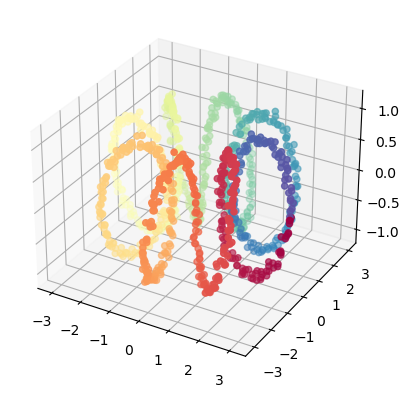

In [22]:
x,y,z,t = toroidal_helix(N= 1000, sample_rate = 1.0)
fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter(x,y,z, cmap = plt.cm.Spectral_r, c = t)

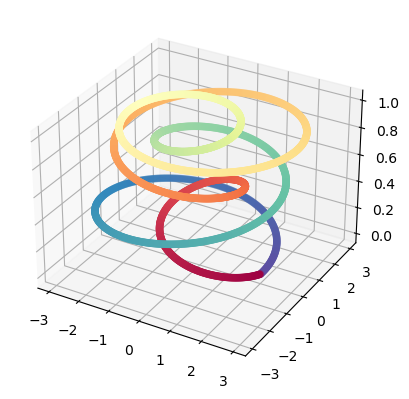

In [33]:
x,y,z,t, A,new_data = get_vhelix(uniform = True)

fig = plt.figure()
ax = plt.axes(projection ='3d')

# plotting
ax.scatter(x,y,z, cmap = plt.cm.Spectral_r, c = t)
#ax.plot(x,y,z)
plt.show()

<Figure size 640x480 with 0 Axes>

/var/folders/52/dh42902j7rv__r8tnhmqf8_w0000gn/T/ipykernel_41360/1736191027.py:2: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  nx.draw_networkx(nx.from_scipy_sparse_matrix(A),


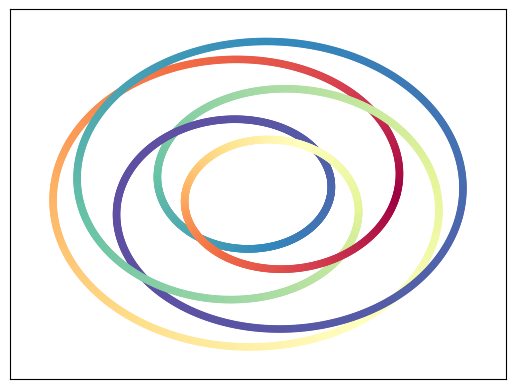

In [34]:
plt.figure()
nx.draw_networkx(nx.from_scipy_sparse_matrix(A),
                 pos={i:[new_data.x[i,0].numpy(),new_data.x[i,1].numpy()] for i in range(new_data.num_nodes)},
                 # to see the "roll" it should by x, y axis
                 node_color=z, cmap='Spectral', with_labels=False, node_size = 20)
plt.show()

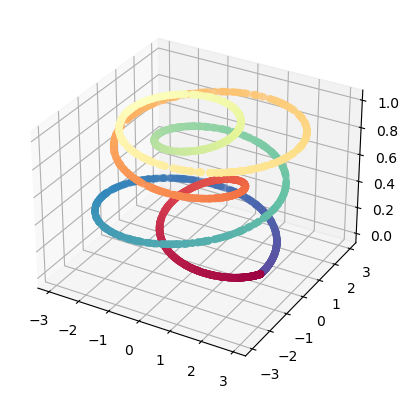

In [35]:
x,y,z,t, A,new_data = get_vhelix(uniform = False, a = 0.5, b = 0.5)

fig = plt.figure()
ax = plt.axes(projection ='3d')

# plotting
ax.scatter(x,y,z, cmap = plt.cm.Spectral_r, c = t)
#ax.plot(x,y,z)
plt.show()

<Figure size 640x480 with 0 Axes>

/var/folders/52/dh42902j7rv__r8tnhmqf8_w0000gn/T/ipykernel_41360/779525772.py:2: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  nx.draw_networkx(nx.from_scipy_sparse_matrix(A),


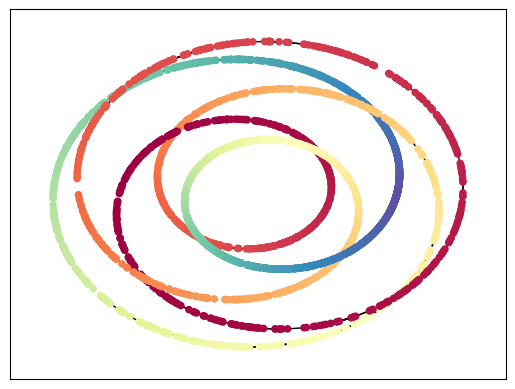

In [36]:
plt.figure()
nx.draw_networkx(nx.from_scipy_sparse_matrix(A),
                 pos={i:[new_data.x[i,0].numpy(),new_data.x[i,1].numpy()] for i in range(new_data.num_nodes)},
                 # to see the "roll" it should by x, y axis
                 node_color=z, cmap='Spectral_r', with_labels=False, node_size = 20)
plt.show()

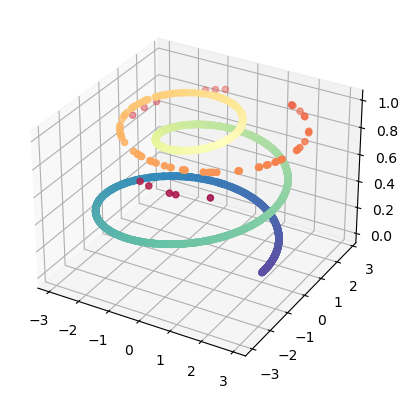

In [37]:
x,y,z,t, A,new_data = get_vhelix(uniform = False, a = 1, b = 5)

fig = plt.figure()
ax = plt.axes(projection ='3d')

# plotting
ax.scatter(x,y,z, cmap = plt.cm.Spectral_r, c = t)
#ax.plot(x,y,z)
plt.show()

<Figure size 640x480 with 0 Axes>

/var/folders/52/dh42902j7rv__r8tnhmqf8_w0000gn/T/ipykernel_41360/3349307350.py:2: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  nx.draw_networkx(nx.from_scipy_sparse_matrix(A),


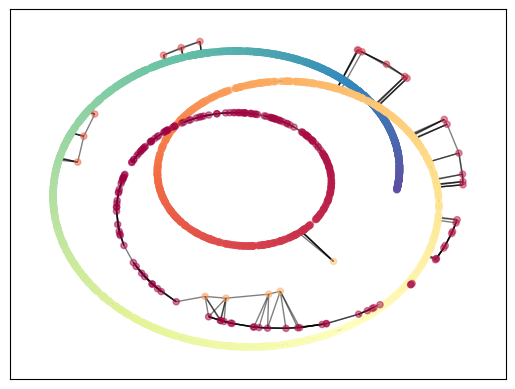

In [38]:
plt.figure()
nx.draw_networkx(nx.from_scipy_sparse_matrix(A),
                 pos={i:[new_data.x[i,0].numpy(),new_data.x[i,1].numpy()] for i in range(new_data.num_nodes)},
                 # to see the "roll" it should by x, y axis
                 node_color=z, cmap='Spectral_r', with_labels=False, node_size = 20, alpha = 0.5)
plt.show()

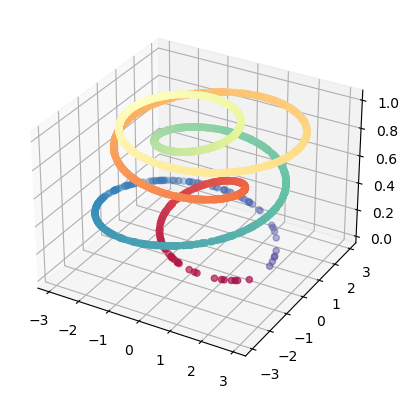

In [39]:
x,y,z,t, A,new_data = get_vhelix(uniform = False, a = 2, b = 2)

fig = plt.figure()
ax = plt.axes(projection ='3d')

# plotting
ax.scatter(x,y,z, cmap = plt.cm.Spectral_r, c = t)
#ax.plot(x,y,z)
plt.show()

<Figure size 640x480 with 0 Axes>

/var/folders/52/dh42902j7rv__r8tnhmqf8_w0000gn/T/ipykernel_41360/779525772.py:2: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  nx.draw_networkx(nx.from_scipy_sparse_matrix(A),


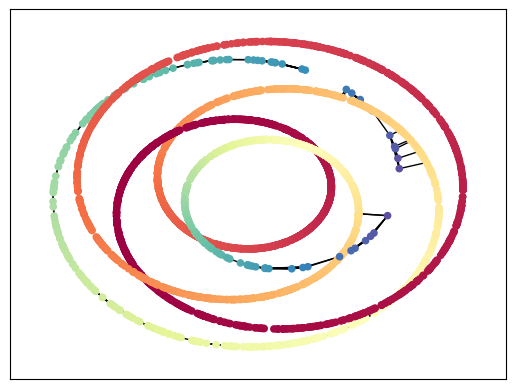

In [40]:
plt.figure()
nx.draw_networkx(nx.from_scipy_sparse_matrix(A),
                 pos={i:[new_data.x[i,0].numpy(),new_data.x[i,1].numpy()] for i in range(new_data.num_nodes)},
                 # to see the "roll" it should by x, y axis
                 node_color=z, cmap='Spectral_r', with_labels=False, node_size = 20)
plt.show()

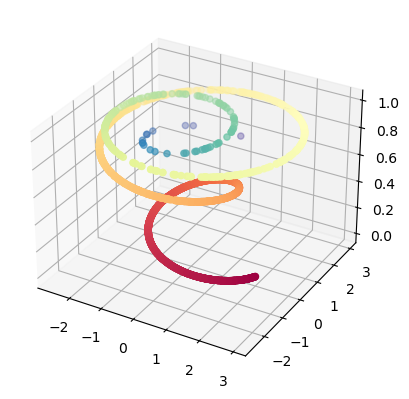

In [41]:
x,y,z,t, A,new_data = get_vhelix(uniform = False, a = 5, b = 1)

fig = plt.figure()
ax = plt.axes(projection ='3d')

# plotting
ax.scatter(x,y,z, cmap = plt.cm.Spectral_r, c = t)
#ax.plot(x,y,z)
plt.show()

<Figure size 640x480 with 0 Axes>

/var/folders/52/dh42902j7rv__r8tnhmqf8_w0000gn/T/ipykernel_41360/779525772.py:2: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  nx.draw_networkx(nx.from_scipy_sparse_matrix(A),


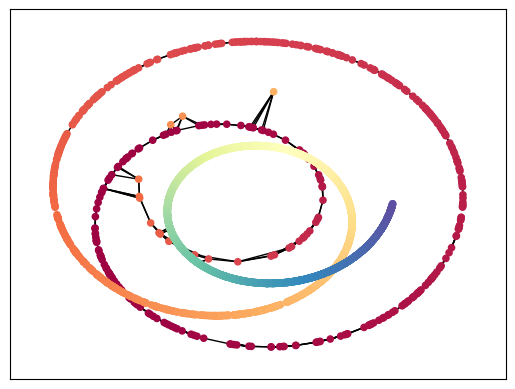

In [42]:
plt.figure()
nx.draw_networkx(nx.from_scipy_sparse_matrix(A),
                 pos={i:[new_data.x[i,0].numpy(),new_data.x[i,1].numpy()] for i in range(new_data.num_nodes)},
                 # to see the "roll" it should by x, y axis
                 node_color=z, cmap='Spectral_r', with_labels=False, node_size = 20)
plt.show()

In [43]:
cd /Users/sowonjeong/Documents/GitHub/GNN-Geometry

/Users/sowonjeong/Documents/GitHub/GNN-Geometry


In [44]:
from models.dgi import *
from models.train_models import train_dgi
from models.baseline_models import *

In [45]:
cd /Users/sowonjeong/Documents/GitHub/GNN-Geometry/notebook

/Users/sowonjeong/Documents/GitHub/GNN-Geometry/notebook


In [46]:
_,_,_,t,_,dataset = get_vhelix(uniform = True)

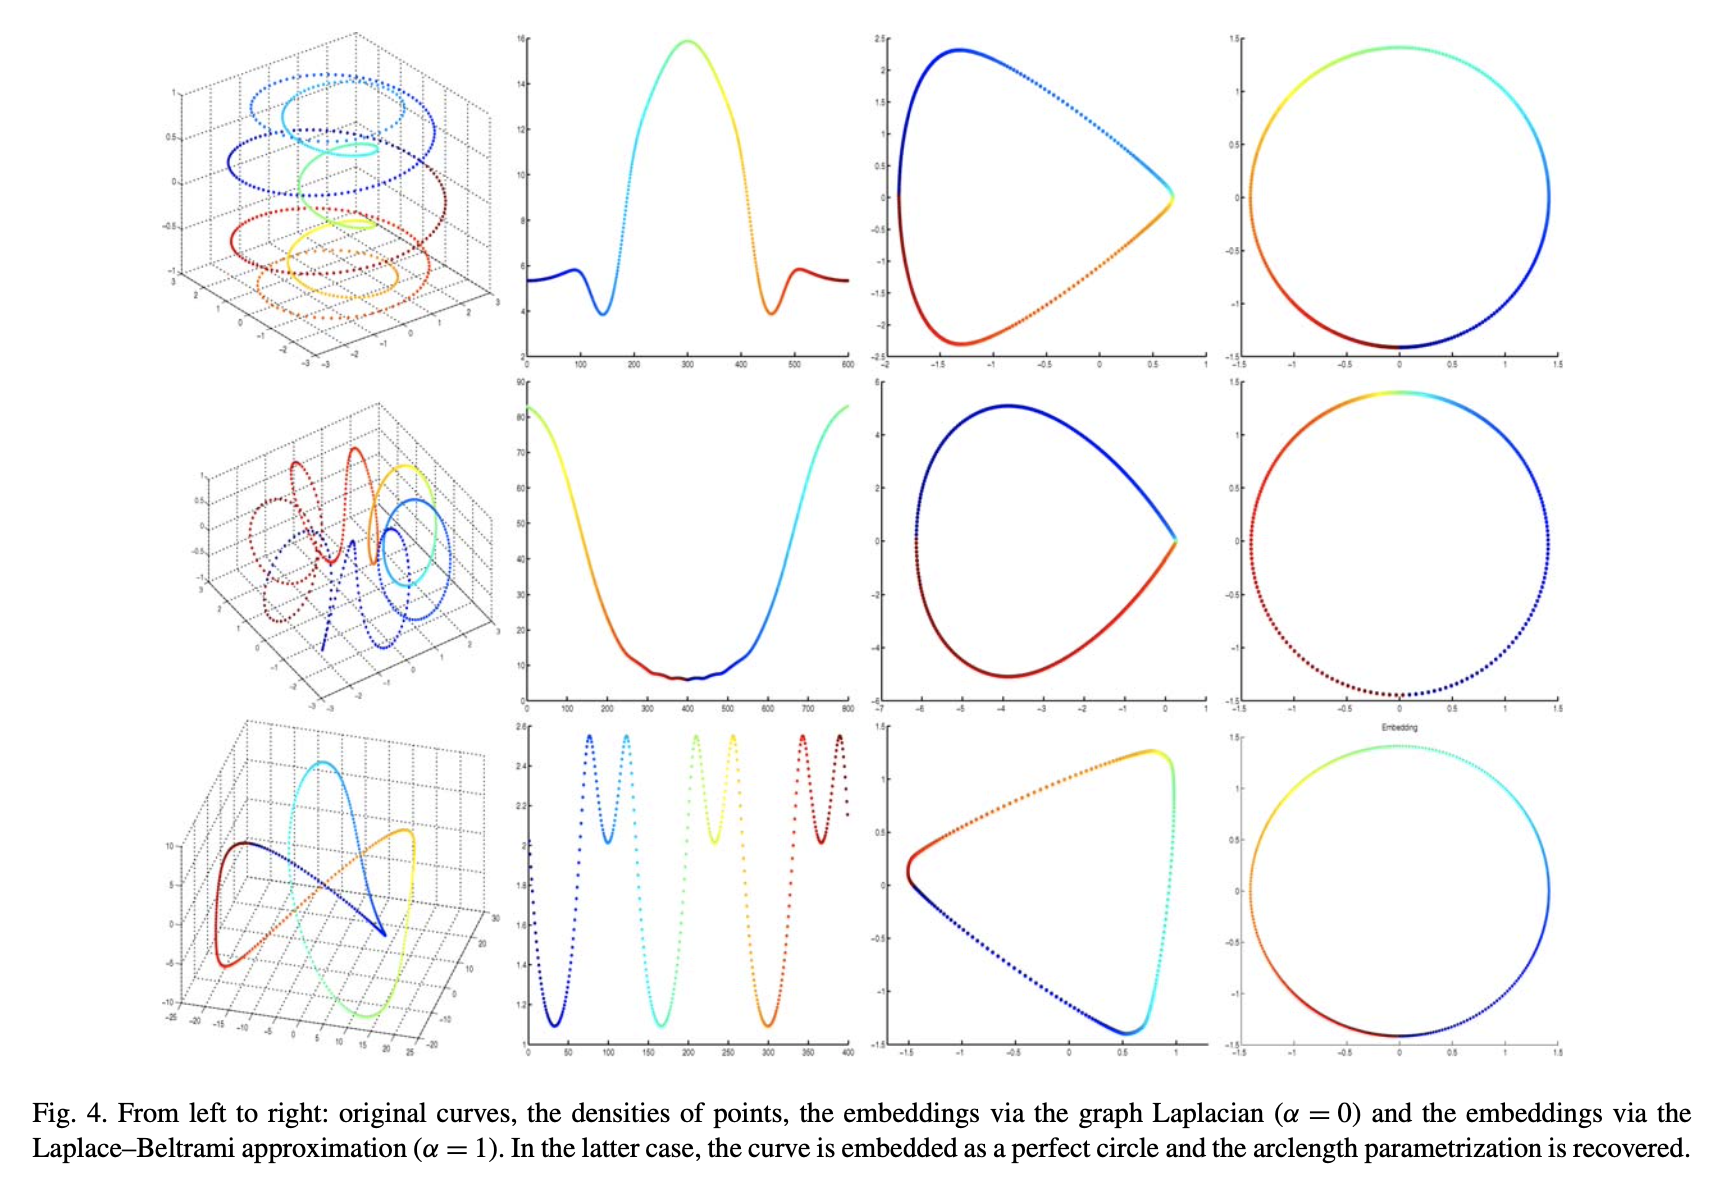

In [53]:
out = {}
alpha = np.arange(0.0,1.1,0.1)
for i in np.arange(10):
    model = train_dgi(dataset,hid_dim = 32, out_dim = 2, n_layers = 2, patience=50,
              epochs=500, lr=1e-2, name_file="1", device=None, alpha = alpha[i], beta = 1, add_self_loops = True, dropout_rate = 0.01)
    out_tmp = model.get_embedding(dataset)
    out[i] = out_tmp

=== train DGI model ===
Epoch=000, loss=0.7322, time=0.0390
Epoch=001, loss=0.6233, time=0.0174
Epoch=002, loss=0.5961, time=0.0180
Epoch=003, loss=0.5921, time=0.0166
Epoch=004, loss=0.5675, time=0.0180
Epoch=005, loss=0.5601, time=0.0199
Epoch=006, loss=0.5551, time=0.0180
Epoch=007, loss=0.5513, time=0.0217
Epoch=008, loss=0.5214, time=0.0207
Epoch=009, loss=0.5135, time=0.0225
Epoch=010, loss=0.5091, time=0.0216
Epoch=011, loss=0.5000, time=0.0231
Epoch=012, loss=0.5015, time=0.0178
Epoch=013, loss=0.4787, time=0.0182
Epoch=014, loss=0.4910, time=0.0162
Epoch=015, loss=0.4707, time=0.0186
Epoch=016, loss=0.4763, time=0.0170
Epoch=017, loss=0.4686, time=0.0162
Epoch=018, loss=0.4536, time=0.0197
Epoch=019, loss=0.4537, time=0.0173
Epoch=020, loss=0.4370, time=0.0182
Epoch=021, loss=0.4444, time=0.0202
Epoch=022, loss=0.4304, time=0.0196
Epoch=023, loss=0.4332, time=0.0190
Epoch=024, loss=0.4137, time=0.0188
Epoch=025, loss=0.4182, time=0.0181
Epoch=026, loss=0.4191, time=0.0199
Epoc

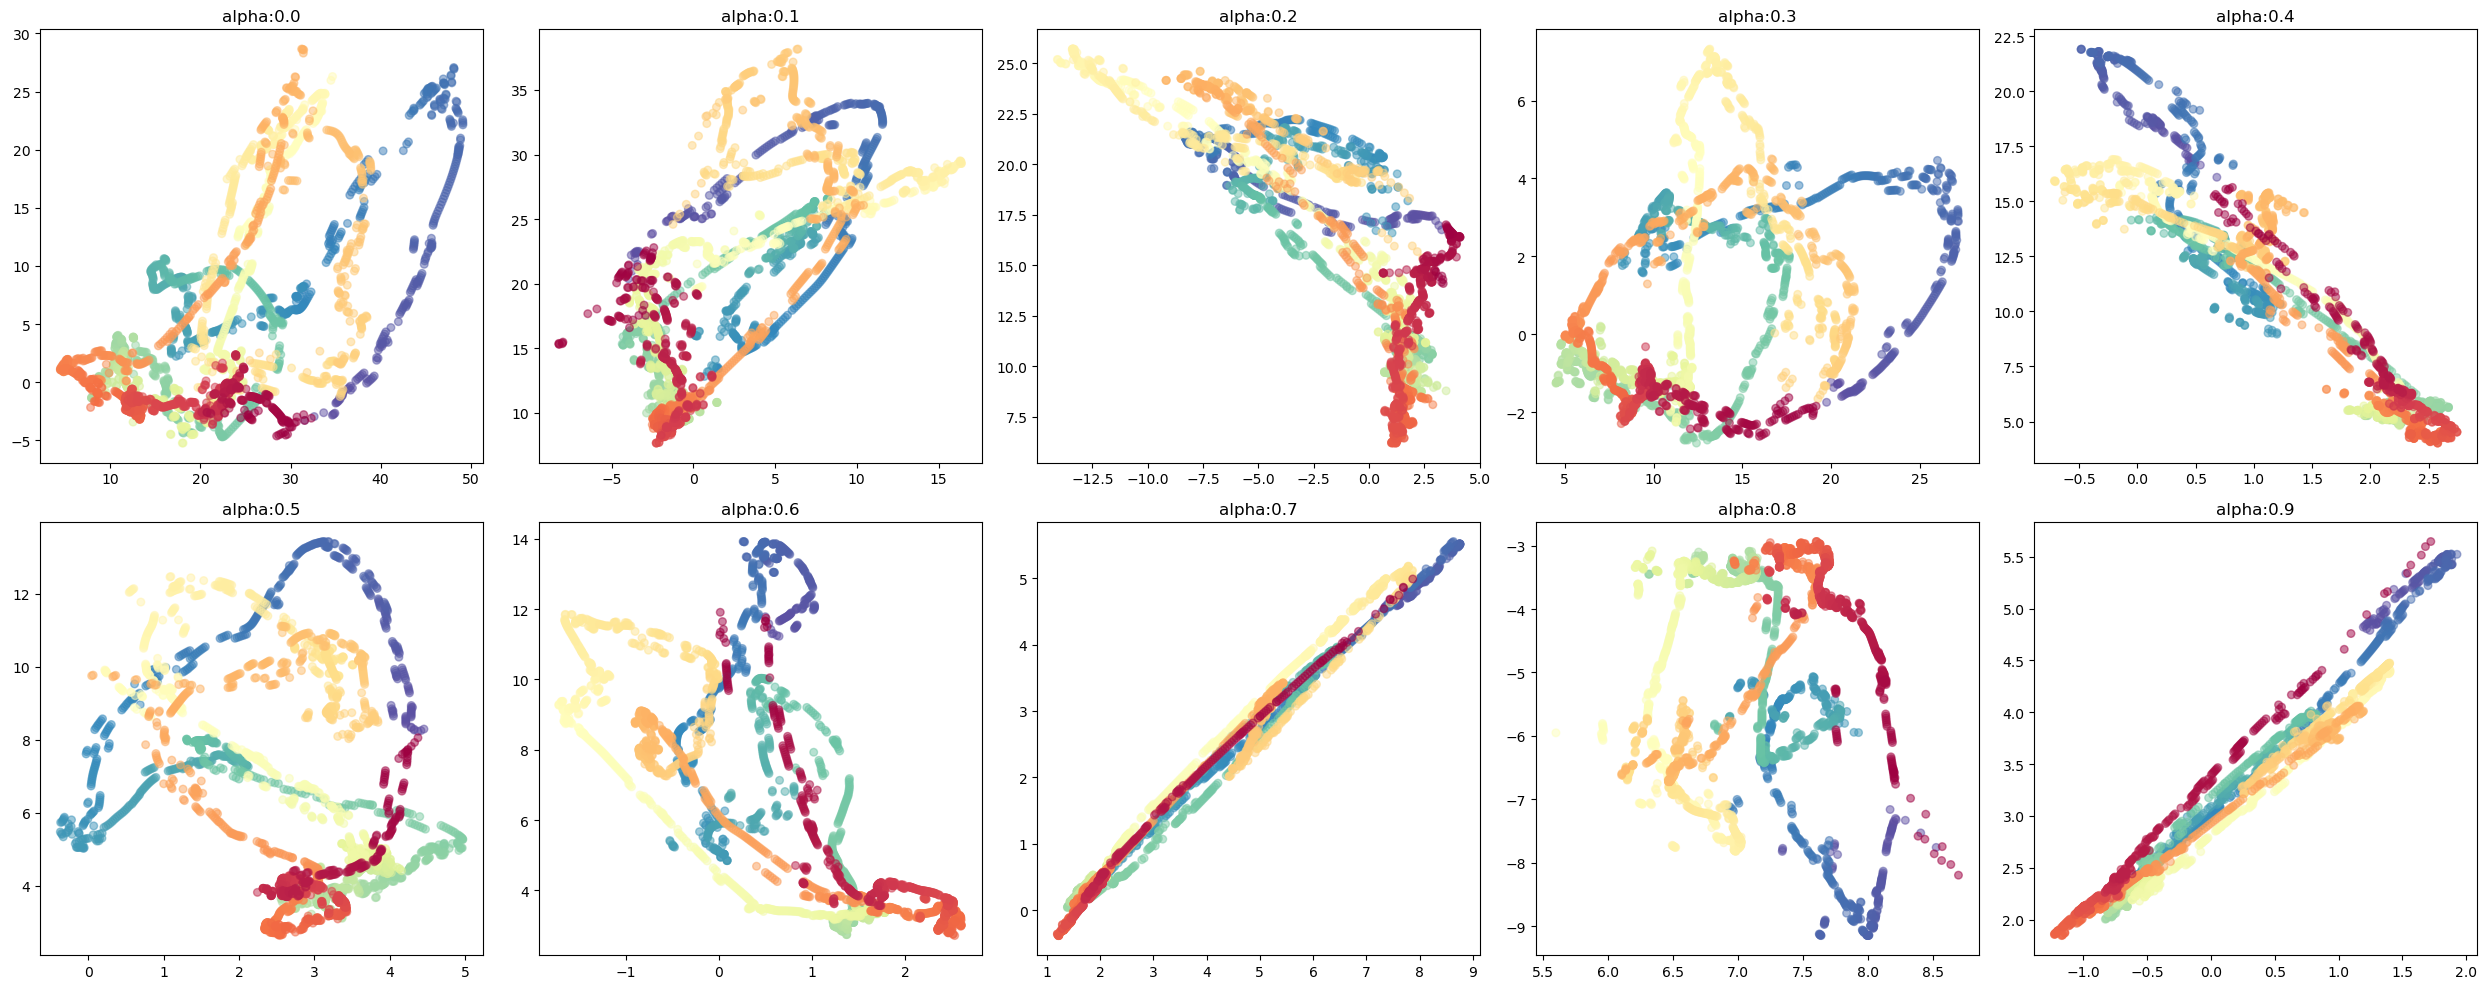

In [54]:
# dropout = 0.01
num = 10
num_row = 2
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(5*num_col,5*num_row))
for i in range(num):
    ax = axes[i // num_col, i % num_col]
    _ = ax.scatter(out[i].detach().numpy()[:,0],out[i].detach().numpy()[:,1], c = t, cmap = plt.cm.Spectral_r, s = 30, alpha = 0.5)
    _ = ax.set_title('alpha:' + str(round(alpha[i],1)))
plt.tight_layout()
plt.show()

In [49]:
from models.grace import *
from models.train_models import train_grace
from models.baseline_models import *

In [50]:
out = {}
alpha = np.arange(0.0,1.1,0.1)
for i in np.arange(10):
    model = train_grace(dataset, 32, 2, n_layers=1, tau=0.5,
                epochs=500, wd=1e-3, lr=5e-1, fmr=0.2, edr =0.5,
                proj="nonlinear-hid", name_file="test", device=None,
                gnn_type="symmetric", alpha=alpha[i], beta = 1,add_self_loops= True)
    out_tmp = model.get_embedding(dataset)
    out[i] = out_tmp


=== train GRACE model ===
Epoch=000, loss=8.8292
Epoch=001, loss=8.6623
Epoch=002, loss=8.7874
Epoch=003, loss=8.8304
Epoch=004, loss=8.6637
Epoch=005, loss=8.6847
Epoch=006, loss=8.7014
Epoch=007, loss=8.6936
Epoch=008, loss=8.7071
Epoch=009, loss=8.6083
Epoch=010, loss=8.4485
Epoch=011, loss=8.2476
Epoch=012, loss=8.1201
Epoch=013, loss=8.2457
Epoch=014, loss=9.1155
Epoch=015, loss=8.3017
Epoch=016, loss=9.0723
Epoch=017, loss=8.2024
Epoch=018, loss=8.1327
Epoch=019, loss=9.1882
Epoch=020, loss=8.0413
Epoch=021, loss=9.2843
Epoch=022, loss=8.0853
Epoch=023, loss=8.0725
Epoch=024, loss=8.0905
Epoch=025, loss=8.1356
Epoch=026, loss=8.1334
Epoch=027, loss=8.9661
Epoch=028, loss=8.0490
Epoch=029, loss=9.1735
Epoch=030, loss=8.0633
Epoch=031, loss=8.0533
Epoch=032, loss=9.1319
Epoch=033, loss=8.8950
Epoch=034, loss=8.2866
Epoch=035, loss=8.9860
Epoch=036, loss=8.1006
Epoch=037, loss=8.1039
Epoch=038, loss=8.0522
Epoch=039, loss=8.0526
Epoch=040, loss=8.3655
Epoch=041, loss=9.1657
Epoch=04

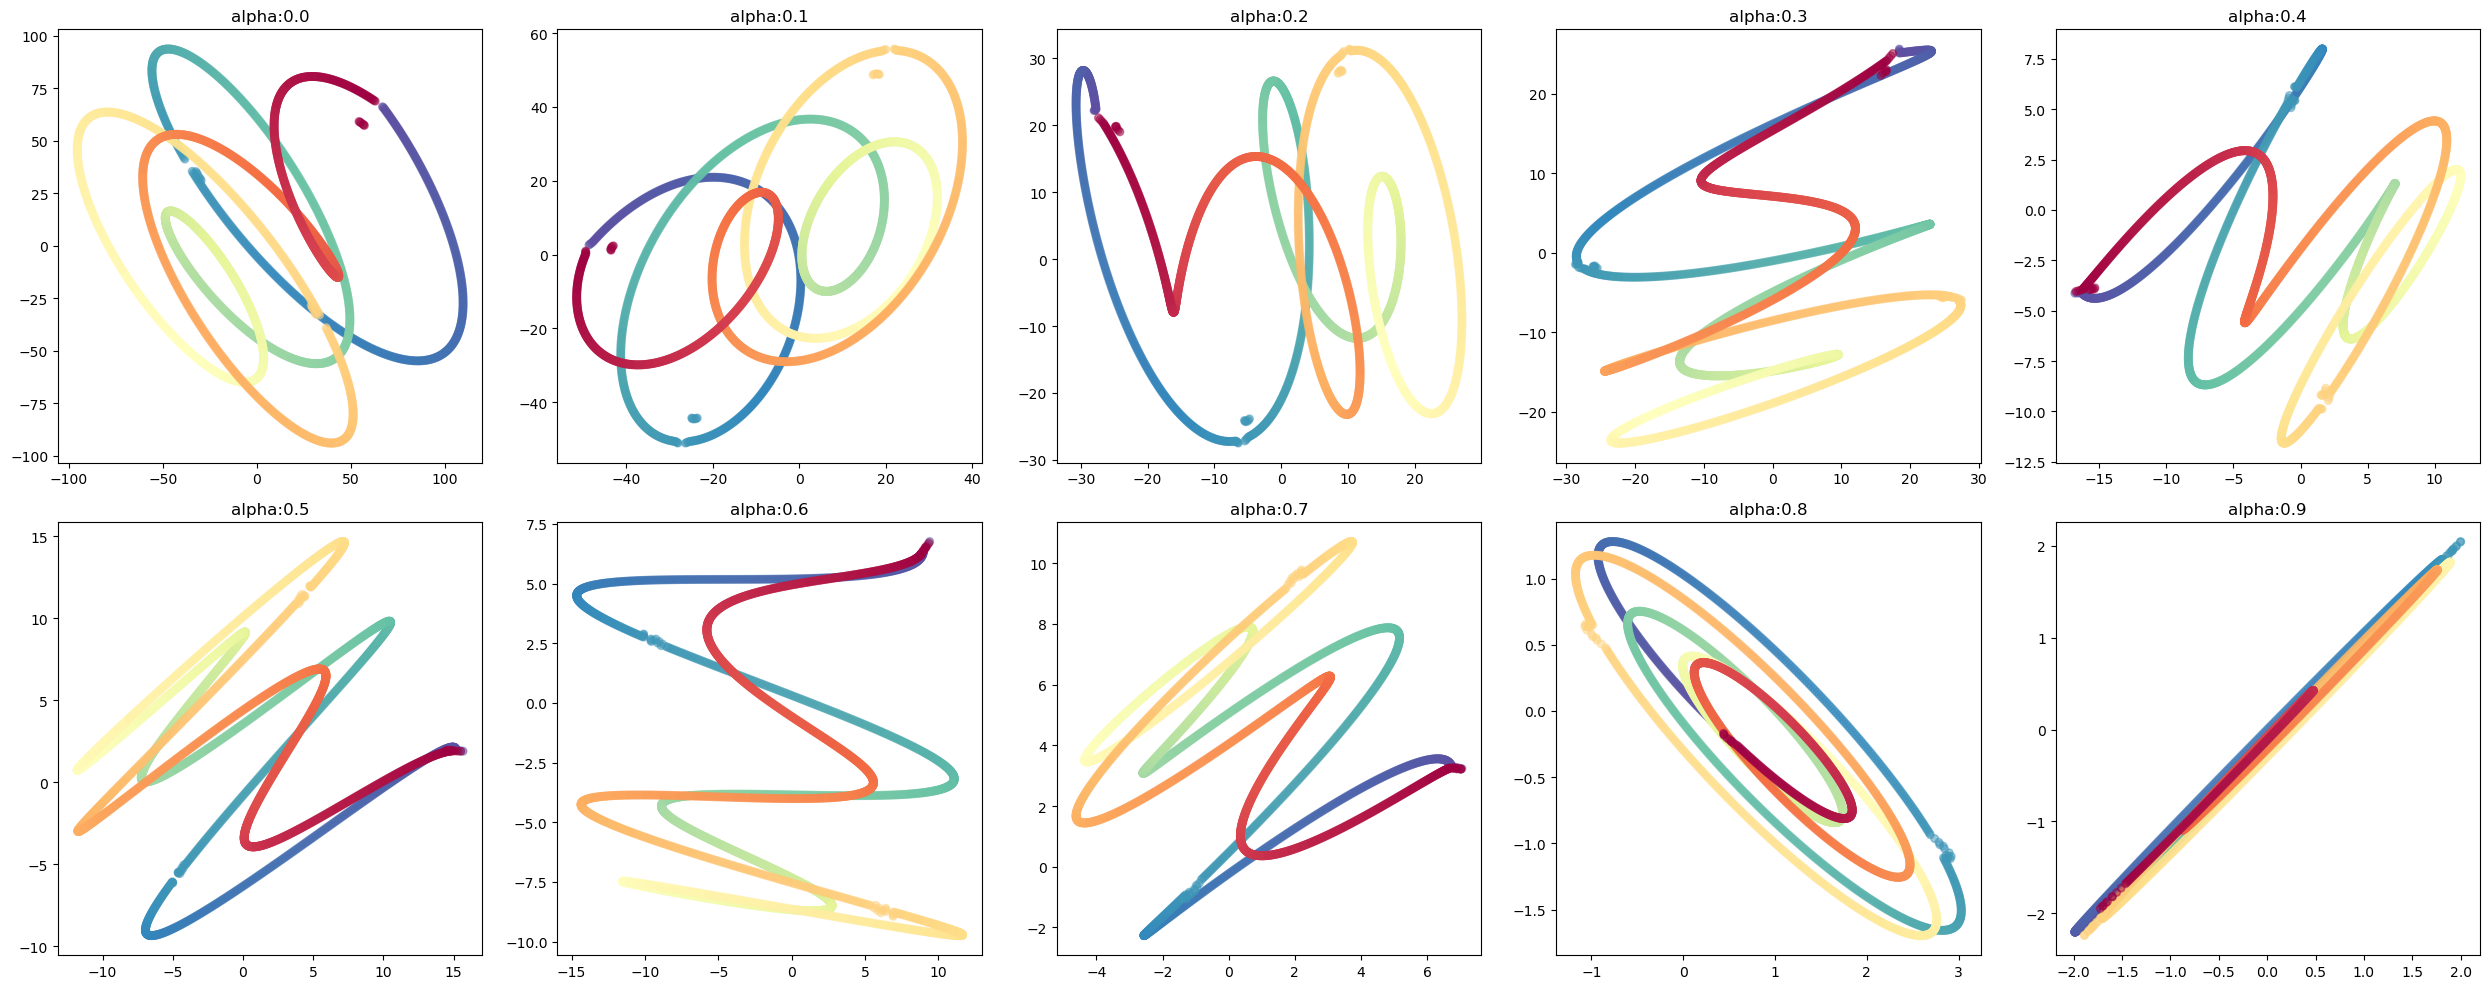

In [52]:
num = 10
num_row = 2
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(5*num_col,5*num_row))
for i in range(num):
    ax = axes[i // num_col, i % num_col]
    _ = ax.scatter(out[i].detach().numpy()[:,0],out[i].detach().numpy()[:,1], c = t, cmap = plt.cm.Spectral_r, s = 30, alpha = 0.5)
    _ = ax.set_title('alpha:' + str(round(alpha[i],1)))
plt.tight_layout()
plt.show()